# Info Dataset

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

- Number of Instances: 1797
- Number of Attributes: 64
- Attribute Information: 8x8 image of integer pixels in the range 0..16.
- Missing Attribute Values: None
- Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
- Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is an integer in the range
0..16. This reduces dimensionality and gives invariance to small
distortions.

For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G.
T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C.
L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469,
1994.

|details-start|
**References**
|details-split|

- C. Kaynak (1995) Methods of Combining Multiple Classifiers and Their
  Applications to Handwritten Digit Recognition, MSc Thesis, Institute of
  Graduate Studies in Science and Engineering, Bogazici University.
- E. Alpaydin, C. Kaynak (1998) Cascading Classifiers, Kybernetika.
- Ken Tang and Ponnuthurai N. Suganthan and Xi Yao and A. Kai Qin.
  Linear dimensionalityreduction using relevance weighted LDA. School of
  Electrical and Electronic Engineering Nanyang Technological University.
  2005.
- Claudio Gentile. A New Approximate Maximal Margin Classification
  Algorithm. NIPS. 2000.

|details-end|


# Pemodelan

(Insert gambar arsitektur model...) 
- Plan: 2 Layer Perceptron (Hidden Layer: 32 Neuron ReLU, Output Layer: 2 Layer Sigmoid)

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import display # Format visual pada tabel.
import seaborn as sns

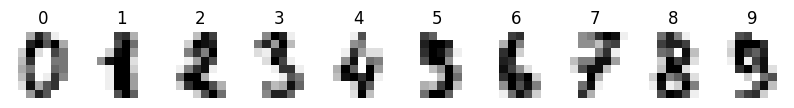

In [9]:
# Loading all the digits dataset (image)
digits = load_digits()
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

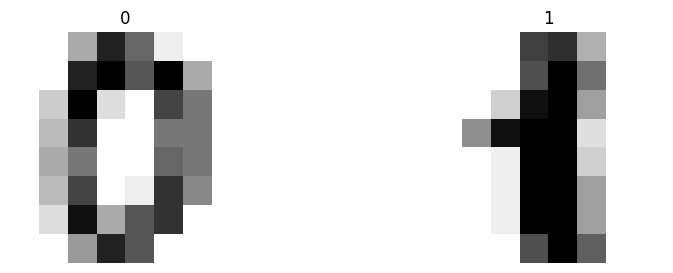

In [12]:
# Loading only digits 0 and 1 (image)
digits = load_digits(n_class=2)
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

In [10]:
# Loading the dataset into a dataframe
raw = load_digits(as_frame=True, n_class=2)
df_digit = raw.frame
df_digit.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0,1
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0


In [11]:
# Class Count
df_digit["target"].value_counts()

target
1    182
0    178
Name: count, dtype: int64

In [ ]:
# Activation function (sigmoid)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Forward propagation
def forward_prop(X, W1, W2, b1, b2):
    z1 = np.dot(X, W1.T) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2.T) + b2
    a2 = sigmoid(z2)
    return a1, a2

# Backpropagation
def backprop(X, y, a1, a2, W1, W2):
    delta2 = a2 - y
    W2_grad = np.dot(a1.T, delta2)
    b2_grad = np.sum(delta2, axis=0)
    delta1 = np.dot(delta2, W2) * a1 * (1 - a1)
    W1_grad = np.dot(X.T, delta1)
    b1_grad = np.sum(delta1, axis=0)
    return W1_grad, b1_grad, W2_grad, b2_grad

In [41]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.activations = []
        self.activate = self.sigmoid
        self.activate_derivative = self.sigmoid_derivative
    
        # Initialize weights and biases
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i+1], layers[i]))            
            self.biases.append(np.zeros((1, layers[i+1])))
        
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_propagation(self, X):
        self.activations = []
        activation = X
        for i in range(len(self.weights)):
            activation = self.activate(np.dot(activation, self.weights[i]) + self.biases[i])
            self.activations.append(activation)
        return activation
    
    def backward_propagation(self, X, y, output):
        error = y - output
        delta = error * self.activate_derivative(self.activations[-1])
        
        for i in range(len(self.weights) - 1, -1, -1):
            weight_delta = np.dot(self.activations[i].T, delta)
            bias_delta = np.sum(delta, axis=0, keepdims=True)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i]) * self.activate_derivative(self.activations[i-1])
            
            self.weights[i] += weight_delta.T
            self.biases[i] += bias_delta
    
    def fit(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.forward_propagation(X)
            self.backward_propagation(X, y, output)
    
    def predict(self, X):
        return self.forward_propagation(X)

In [42]:
nn = NeuralNetwork([2, 4, 1])

# Training data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Train the neural network
nn.fit(X, y, epochs=10000, learning_rate=0.1)

# Make predictions
predictions = nn.predict(X)
print(predictions)

ValueError: shapes (4,2) and (4,2) not aligned: 2 (dim 1) != 4 (dim 0)

# Pemodelan Dengan Library

# Trial & Error

In [5]:
# Loop Display Dataframe
df = pd.DataFrame({"Nama": ["Andi", "Suryo"], "NIM":[2105, 210]})
for x in range(5):
    display(df)
    print(" ")

,Nama,NIM
0,Andi,2105
1,Suryo,210


,Nama,NIM
0,Andi,2105
1,Suryo,210


,Nama,NIM
0,Andi,2105
1,Suryo,210


,Nama,NIM
0,Andi,2105
1,Suryo,210


,Nama,NIM
0,Andi,2105
1,Suryo,210
